## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2025-08-05 03:52:06.621 | INFO     |  Running on cpu


In [3]:
task = "BlockDrawerBlue"
path = data_root / task / "demos"

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))

2025-08-05 03:52:12.712 | INFO     |  Loading dataset(s): 
2025-08-05 03:52:12.714 | INFO     |    Initializing datasete using /home/jangruhnert/Projects/TapasCalvin/data/BlockDrawerBlue/demos/metadata.json
2025-08-05 03:52:12.720 | INFO     |    Extracted gt object labels [0, 1, 2, 3, 4, 5, 6]
2025-08-05 03:52:12.720 | INFO     |    Extracted tsdf object labels []
2025-08-05 03:52:12.721 | INFO     |    Done! Data contains 5 trajectories.
SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype

In [4]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'static',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([190, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([190]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([190, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([190, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([190, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([190, 3, 256, 256]), device=cpu, dt

In [ ]:
tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,
    add_gripper_action=True,
    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,
    trans_cov_mask_t_pos_corr=False,
    em_steps=50,
    fix_first_component=False,
    fix_last_component=False,
    reg_init_diag=5e-4,  # 5
    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
    use_bic=False,
    drop_redundant_frames=False,
)

#Segment 1 - Bewege über den blauen Block
#Segment 2 - Gehe runter zum blauen Block
#Error     - Roboter geht hoch und greift befor er ganz unten war
#Segment 3 - Gehe hoch
#Segment 4 - Bewege zum Sammelpunkt 

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    repeat_final_step=10, #1
    repeat_first_step=0,
    components_prop_to_len=True,
    min_n_components=1, # Das hier und #1 haben beim roten Block geholfen, aber hier nicht
    velocity_threshold=0.001,
    # max_idx_distance=8,
    min_end_distance=20,
    min_len=8,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [7]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-08-05 03:52:29.102 | INFO     |  Fitting AutoTPGMM
2025-08-05 03:52:29.103 | INFO     |  Performing fitting actions: [INIT]
2025-08-05 03:52:29.103 | INFO     |  Segmenting trajectories


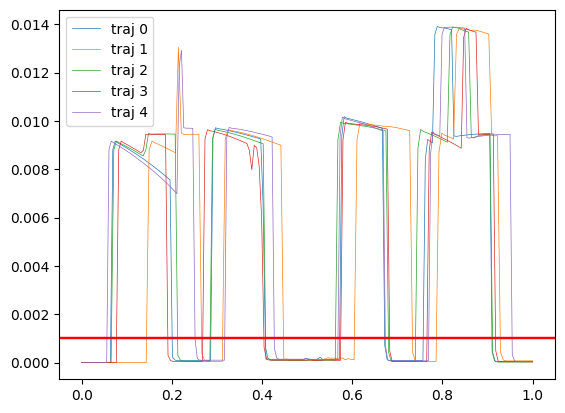

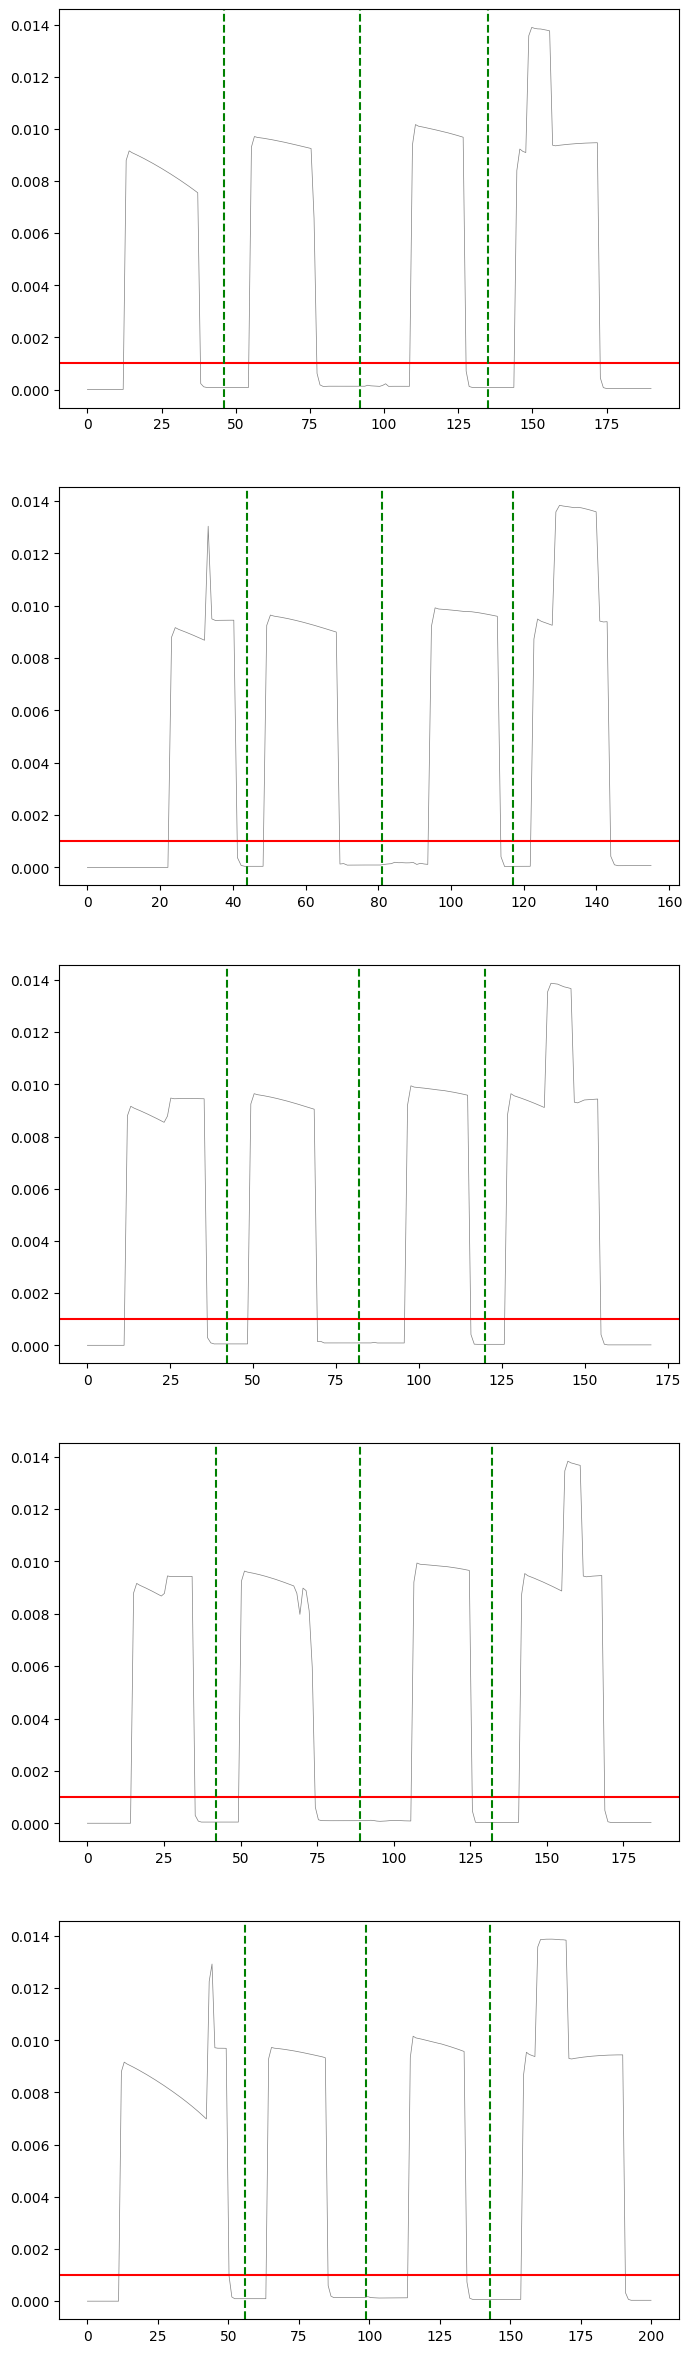

2025-08-05 03:52:30.547 | INFO     |  Creating segement of demos.
2025-08-05 03:52:30.560 | INFO     |  Subsampling to length 55 using strategy mean-length.
2025-08-05 03:52:30.562 | INFO     |  Creating segement of demos.
2025-08-05 03:52:30.575 | INFO     |  Subsampling to length 51 using strategy mean-length.
2025-08-05 03:52:30.577 | INFO     |  Creating segement of demos.
2025-08-05 03:52:30.587 | INFO     |  Subsampling to length 49 using strategy mean-length.
2025-08-05 03:52:30.589 | INFO     |  Creating segement of demos.
2025-08-05 03:52:30.598 | INFO     |  Subsampling to length 59 using strategy mean-length.
2025-08-05 03:52:30.600 | INFO     |  ... created 4 segments
2025-08-05 03:52:30.600 | INFO     |    Fitting candidate frame 1/10
2025-08-05 03:52:30.601 | INFO     |    Creating partial frame view of demos.
2025-08-05 03:52:30.610 | INFO     |    Manifold: TIME x R3 x QUAT x R1
2025-08-05 03:52:30.611 | INFO     |    Changing number of components to 2
2025-08-05 03:52:

Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:52:30.832 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:52:30.832 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:52:31.089 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:52:31.089 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:52:31.345 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:52:31.346 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:52:31.616 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:52:31.617 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:52:31.849 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:52:31.850 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:52:32.079 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:52:32.080 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:52:32.325 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:52:32.325 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:52:32.670 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:52:32.671 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:52:33.010 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:52:33.011 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:52:33.240 | INFO     |  ee_init    score (rel):     -0 (0.317)
2025-08-05 03:52:33.240 | INFO     |  obj000     score (rel):     -0 (0.317)
2025-08-05 03:52:33.240 | INFO     |  obj001     score (rel):     -0 (0.317)
2025-08-05 03:52:33.240 | INFO     |  obj002     score (rel):     -0 (0.317)
2025-08-05 03:52:33.240 | INFO     |  obj003     score (rel):     -0 (0.317)
2025-08-05 03:52:33.241 | INFO     |  obj004     score (rel):     -0 (0.317)
2025-08-05 03:52:33.241 | INFO     |  obj005     score (rel):     -0 (0.317)
2025-08-05 03:52:33.241 | INFO     |  obj006     score (rel):     -0 (0.005)
2025-08-05 03:52:33.241 | INFO     |  obj007     score (rel):     -0 (1.000)
2025-08-05 03:52:33.241 | INFO     |  obj008     score (rel):     -0 (0.003)
2025-08-05 03:52:33.242 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:52:33.245 | INFO     |    Fitting candidate frame 1/10
2025-08-05 03:52:33.245 | INFO     |    Creating partial frame view of demos.
2025-08

Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:52:33.450 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:52:33.451 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:52:33.644 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:52:33.645 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:52:33.860 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:52:33.861 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:52:34.055 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:52:34.056 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:52:34.268 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:52:34.269 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:52:34.489 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:52:34.490 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:52:34.695 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:52:34.696 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:52:34.973 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:52:34.975 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:52:35.298 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:52:35.298 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:52:35.569 | INFO     |  ee_init    score (rel):     -0 (0.069)
2025-08-05 03:52:35.570 | INFO     |  obj000     score (rel):     -0 (0.069)
2025-08-05 03:52:35.570 | INFO     |  obj001     score (rel):     -0 (0.069)
2025-08-05 03:52:35.570 | INFO     |  obj002     score (rel):     -0 (0.069)
2025-08-05 03:52:35.570 | INFO     |  obj003     score (rel):     -0 (0.069)
2025-08-05 03:52:35.570 | INFO     |  obj004     score (rel):     -0 (0.069)
2025-08-05 03:52:35.570 | INFO     |  obj005     score (rel):     -0 (0.069)
2025-08-05 03:52:35.571 | INFO     |  obj006     score (rel):     -0 (0.004)
2025-08-05 03:52:35.571 | INFO     |  obj007     score (rel):     -1 (1.000)
2025-08-05 03:52:35.571 | INFO     |  obj008     score (rel):     -0 (0.002)
2025-08-05 03:52:35.572 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:52:35.575 | INFO     |    Fitting candidate frame 1/10
2025-08-05 03:52:35.575 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:52:35.777 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:52:35.778 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:52:35.974 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:52:35.975 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:52:36.166 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:52:36.167 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:52:36.358 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:52:36.359 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:52:36.560 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:52:36.561 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:52:36.787 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:52:36.788 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:52:37.028 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:52:37.028 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:52:37.297 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:52:37.298 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:52:37.528 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:52:37.529 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:52:37.780 | INFO     |  ee_init    score (rel):     -0 (0.082)
2025-08-05 03:52:37.783 | INFO     |  obj000     score (rel):     -0 (0.082)
2025-08-05 03:52:37.783 | INFO     |  obj001     score (rel):     -0 (0.082)
2025-08-05 03:52:37.783 | INFO     |  obj002     score (rel):     -0 (0.082)
2025-08-05 03:52:37.783 | INFO     |  obj003     score (rel):     -0 (0.082)
2025-08-05 03:52:37.783 | INFO     |  obj004     score (rel):     -0 (0.082)
2025-08-05 03:52:37.783 | INFO     |  obj005     score (rel):     -0 (0.082)
2025-08-05 03:52:37.784 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:52:37.789 | INFO     |    Fitting candidate frame 1/10
2025-08-05 03:52:37.789 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:52:38.090 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:52:38.091 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:52:38.341 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:52:38.341 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:52:38.577 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:52:38.577 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:52:38.818 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:52:38.819 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:52:39.057 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:52:39.057 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:52:39.346 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:52:39.346 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:52:39.752 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:52:39.753 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:52:40.030 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:52:40.031 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:52:40.267 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:52:40.269 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:52:40.534 | INFO     |  ee_init    score (rel):     -0 (0.754)
2025-08-05 03:52:40.535 | INFO     |  obj000     score (rel):     -0 (0.754)
2025-08-05 03:52:40.535 | INFO     |  obj001     score (rel):     -0 (0.754)
2025-08-05 03:52:40.535 | INFO     |  obj002     score (rel):     -0 (0.754)
2025-08-05 03:52:40.535 | INFO     |  obj003     score (rel):     -0 (0.754)
2025-08-05 03:52:40.536 | INFO     |  obj004     score (rel):     -0 (0.754)
2025-08-05 03:52:40.536 | INFO     |  obj005     score (rel):     -0 (0.754)
2025-08-05 03:52:40.536 | INFO     |  obj006     score (rel):     -0 (0.020)
2025-08-05 03:52:40.536 | INFO     |  obj008     score (rel):     -0 (0.012)
2025-08-05 03:52:40.538 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:52:40.634 | INFO     |  Segmented trajs into 4 segments
2025-08-05 03:52:40.654 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.139893 -0.139901 -

Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:52:41.384 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

((array([[1.17e+08, 1.31e+08, 1.46e+08, 1.61e+08, 1.75e+08, 1.88e+08,
          2.00e+08, 2.09e+08, 2.16e+08, 2.21e+08, 2.23e+08, 2.22e+08,
          2.19e+08, 2.13e+08, 2.31e+08, 2.45e+08, 2.54e+08, 2.57e+08,
          2.53e+08, 2.43e+08, 2.27e+08, 2.07e+08, 1.85e+08, 1.61e+08,
          1.36e+08, 1.13e+08, 9.12e+07, 7.21e+07, 5.56e+07, 4.19e+07,
          3.09e+07, 2.22e+07, 1.56e+07, 1.08e+07, 7.25e+06, 4.78e+06,
          3.08e+06, 1.95e+06, 1.20e+06, 9.83e+05, 8.03e+05, 6.47e+05,
          5.14e+05, 4.04e+05, 3.14e+05, 2.40e+05, 1.82e+05, 1.36e+05,
          9.99e+04, 7.28e+04, 5.23e+04, 3.72e+04, 2.61e+04, 1.81e+04,
          1.24e+04, 1.24e+08, 1.48e+08, 1.74e+08, 2.03e+08, 2.34e+08,
          2.66e+08, 2.98e+08, 3.31e+08, 3.62e+08, 3.92e+08, 4.18e+08,
          4.41e+08, 4.60e+08, 4.74e+08, 4.82e+08, 4.84e+08, 4.80e+08,
          4.70e+08, 4.55e+08, 4.35e+08, 4.11e+08, 3.83e+08, 3.53e+08,
          3.21e+08, 2.88e+08, 2.50e+08, 2.11e+08, 1.74e+08, 1.40e+08,
          1.10e+08, 

In [8]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2025-08-05 03:52:43.328 | INFO     |  Did not specify time_based, deciding automatically.
2025-08-05 03:52:43.667 | WARNING  |  Skippig NaN Gaussians.


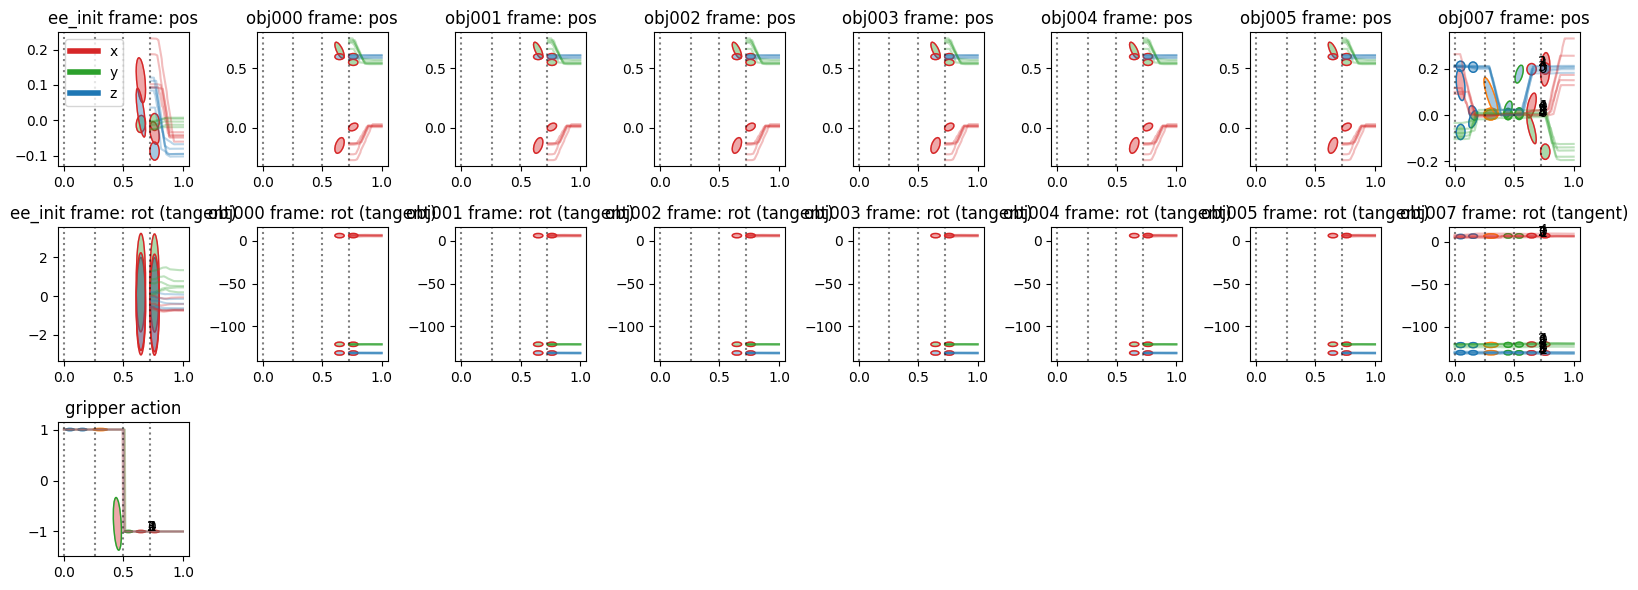

In [9]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-08-05 03:52:49.509 | INFO     |  Fitting AutoTPGMM
2025-08-05 03:52:49.510 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 03:52:49.564 | INFO     |  HMM EM ...
2025-08-05 03:52:49.573 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

2025-08-05 03:52:49.630 | INFO     |  HMM init priors not defined, initializing to uniform
2025-08-05 03:53:03.477 | INFO     |  HMM EM converged


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000,
          1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000,
          1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000,
          1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000,
          1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000,
          9.68e-001, 6.61e-001, 1.71e-001, 1.31e-002, 3.23e-004, 3.04e-006,
          1.32e-008, 3.19e-011, 5.14e-014, 6.80e-017, 7.48e-020, 6.89e-023,
          5.35e-026, 3.54e-029, 2.01e-032, 9.82e-036, 4.18e-039, 1.56e-042,
          5.17e-046, 1.52e-049, 4.03e-053, 9.67e-057, 2.11e-060, 4.26e-064,
          1.88e-066, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000,
          1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000,
          1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000,
          1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000,
          1.

2025-08-05 03:53:31.449 | INFO     |  Did not specify time_based, deciding automatically.


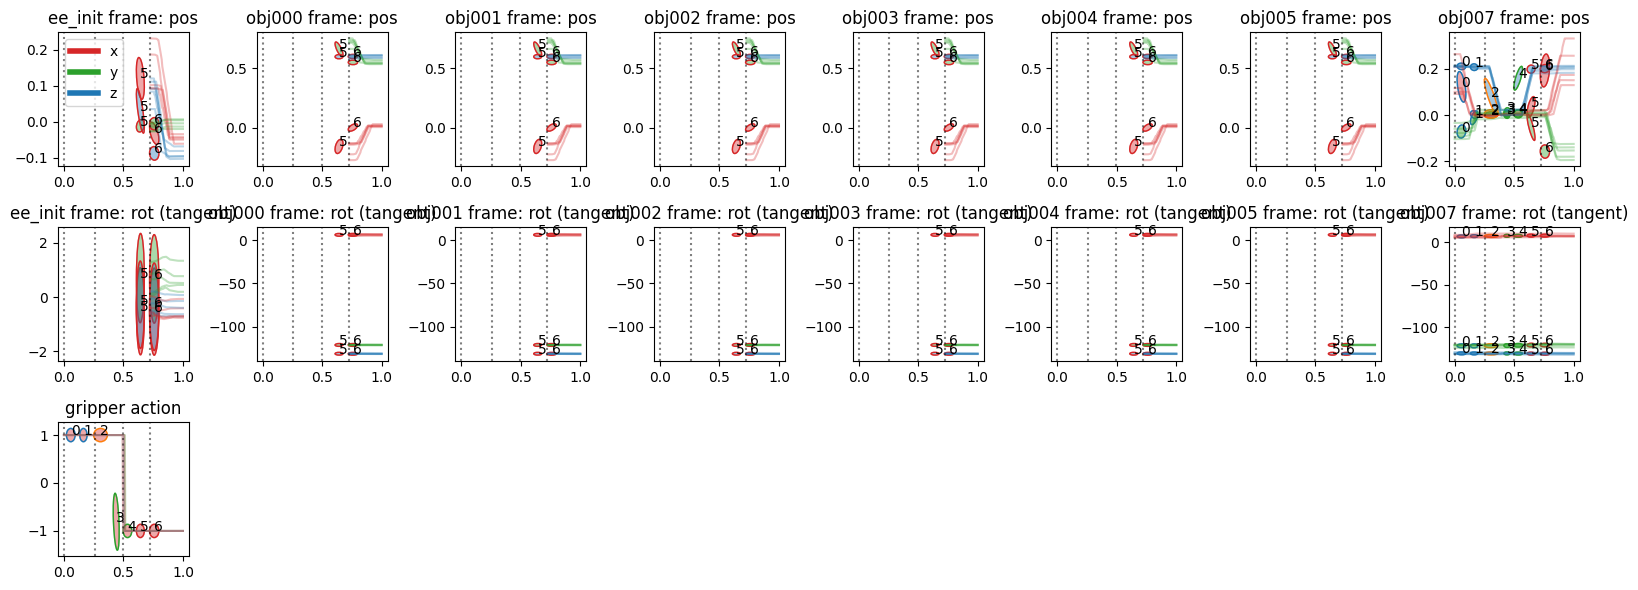

In [11]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

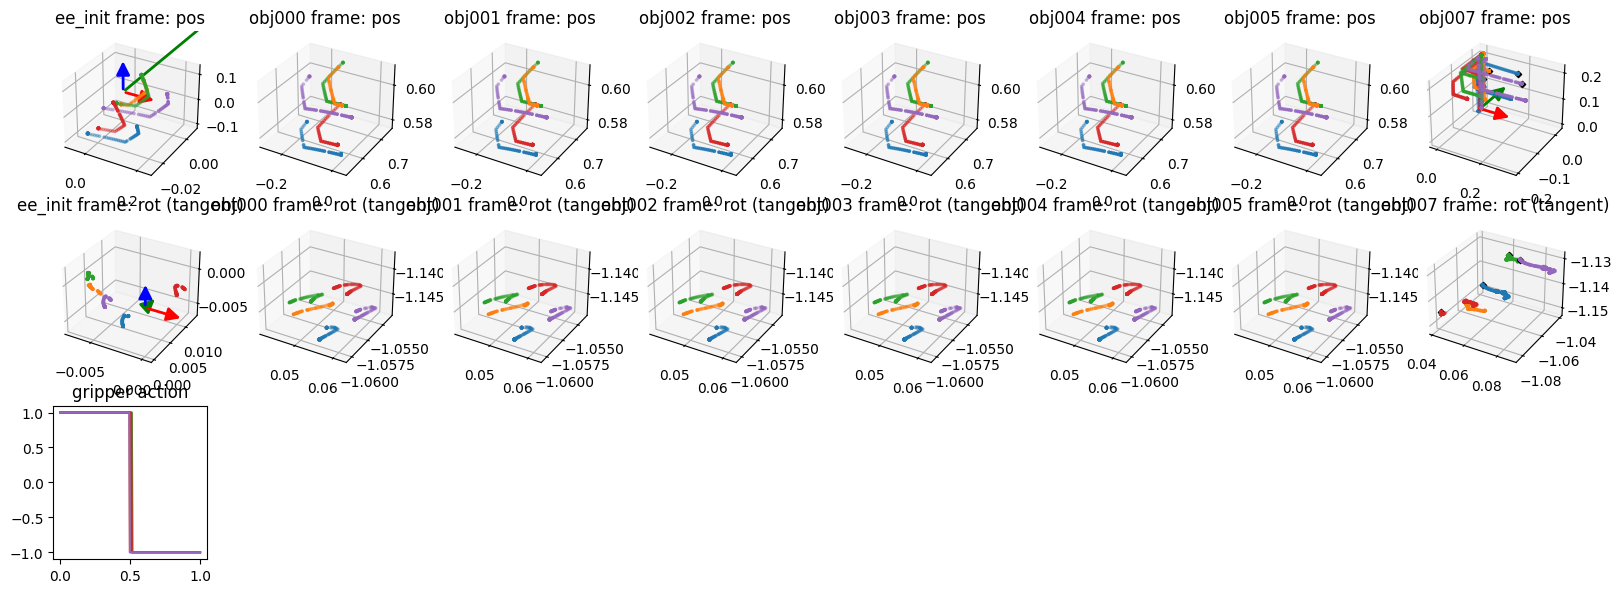

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

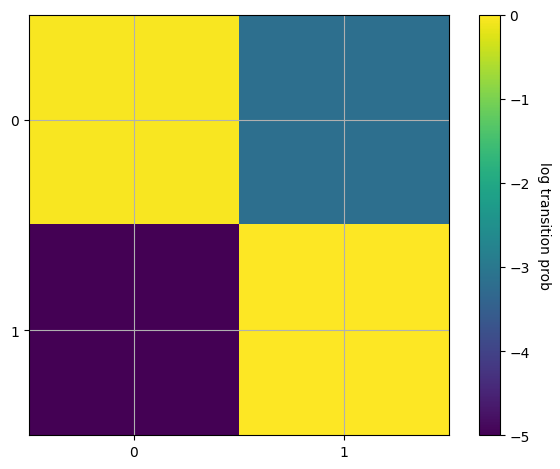

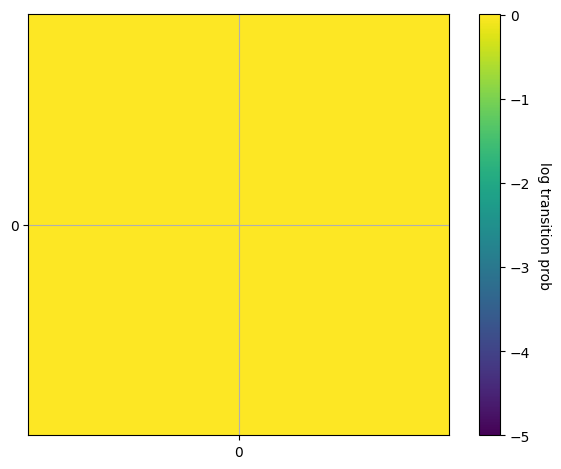

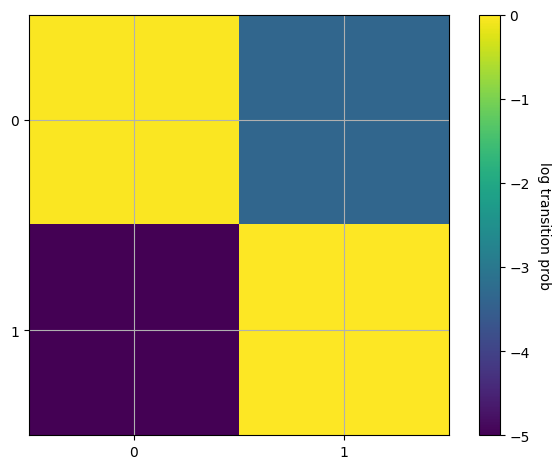

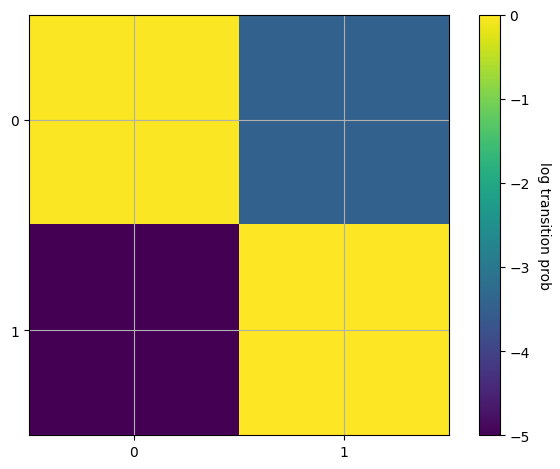

In [13]:
atpgmm.plot_hmm_transition_matrix()

In [14]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2025-08-05 03:53:43.119 | INFO     |  Saving model:


In [15]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-08-05 03:53:43.403 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2025-08-05 03:53:43.498 | INFO     |  Caculated segment transition probabilities: (array([[0.04]]), array([[8.96e-07]]), array([[0.]]))
2025-08-05 03:53:43.499 | WARNING  |  At least one segment transition prob below 5%. Can lead to problems.Consider increasing the diag reg.
2025-08-05 03:53:43.499 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:53:43.541 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 03:53:43.595 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 03:53:43.679 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 03:53:43.771 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 03:53:44.720 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/5 [00:00<?, ?it/s]

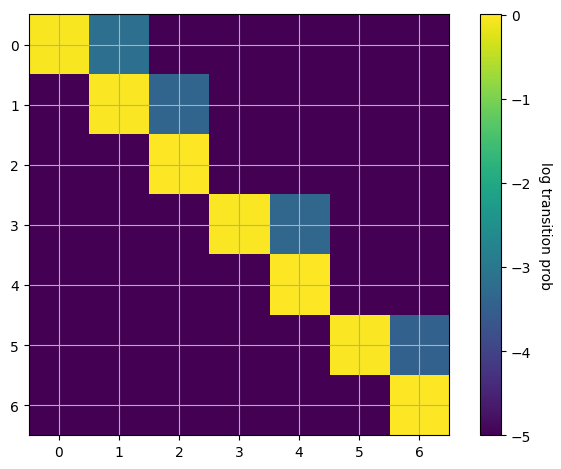

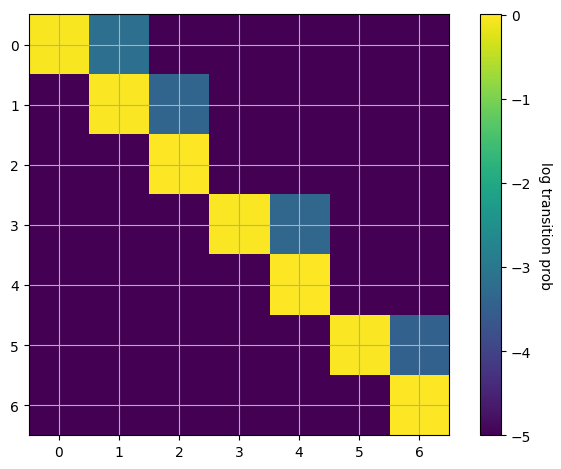

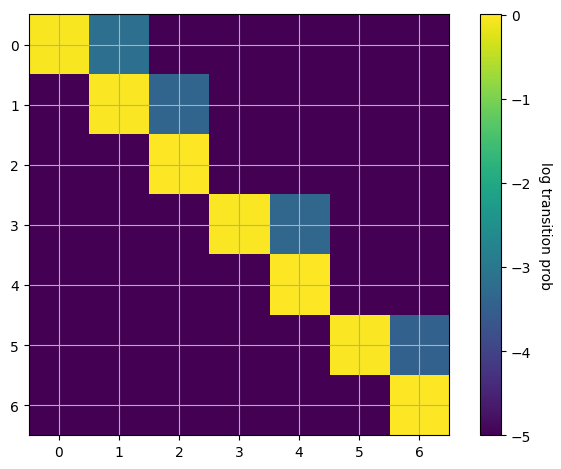

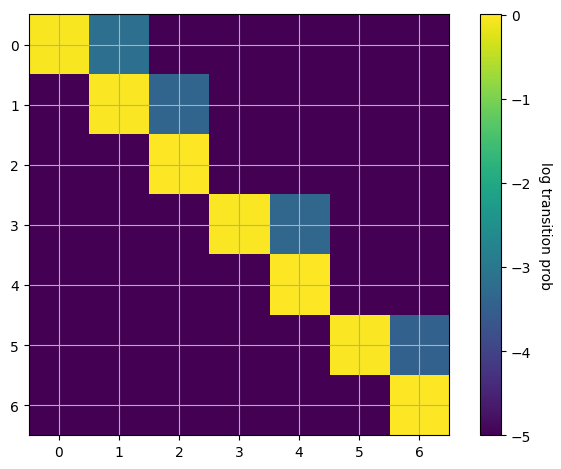

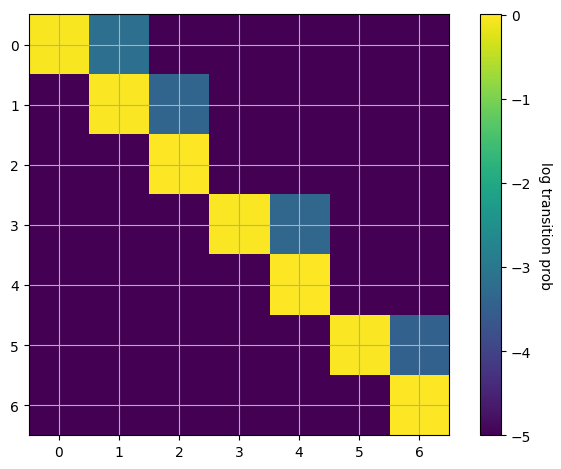

In [16]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-08-05 03:53:57.263 | INFO     |  Taking frame origins from demos.


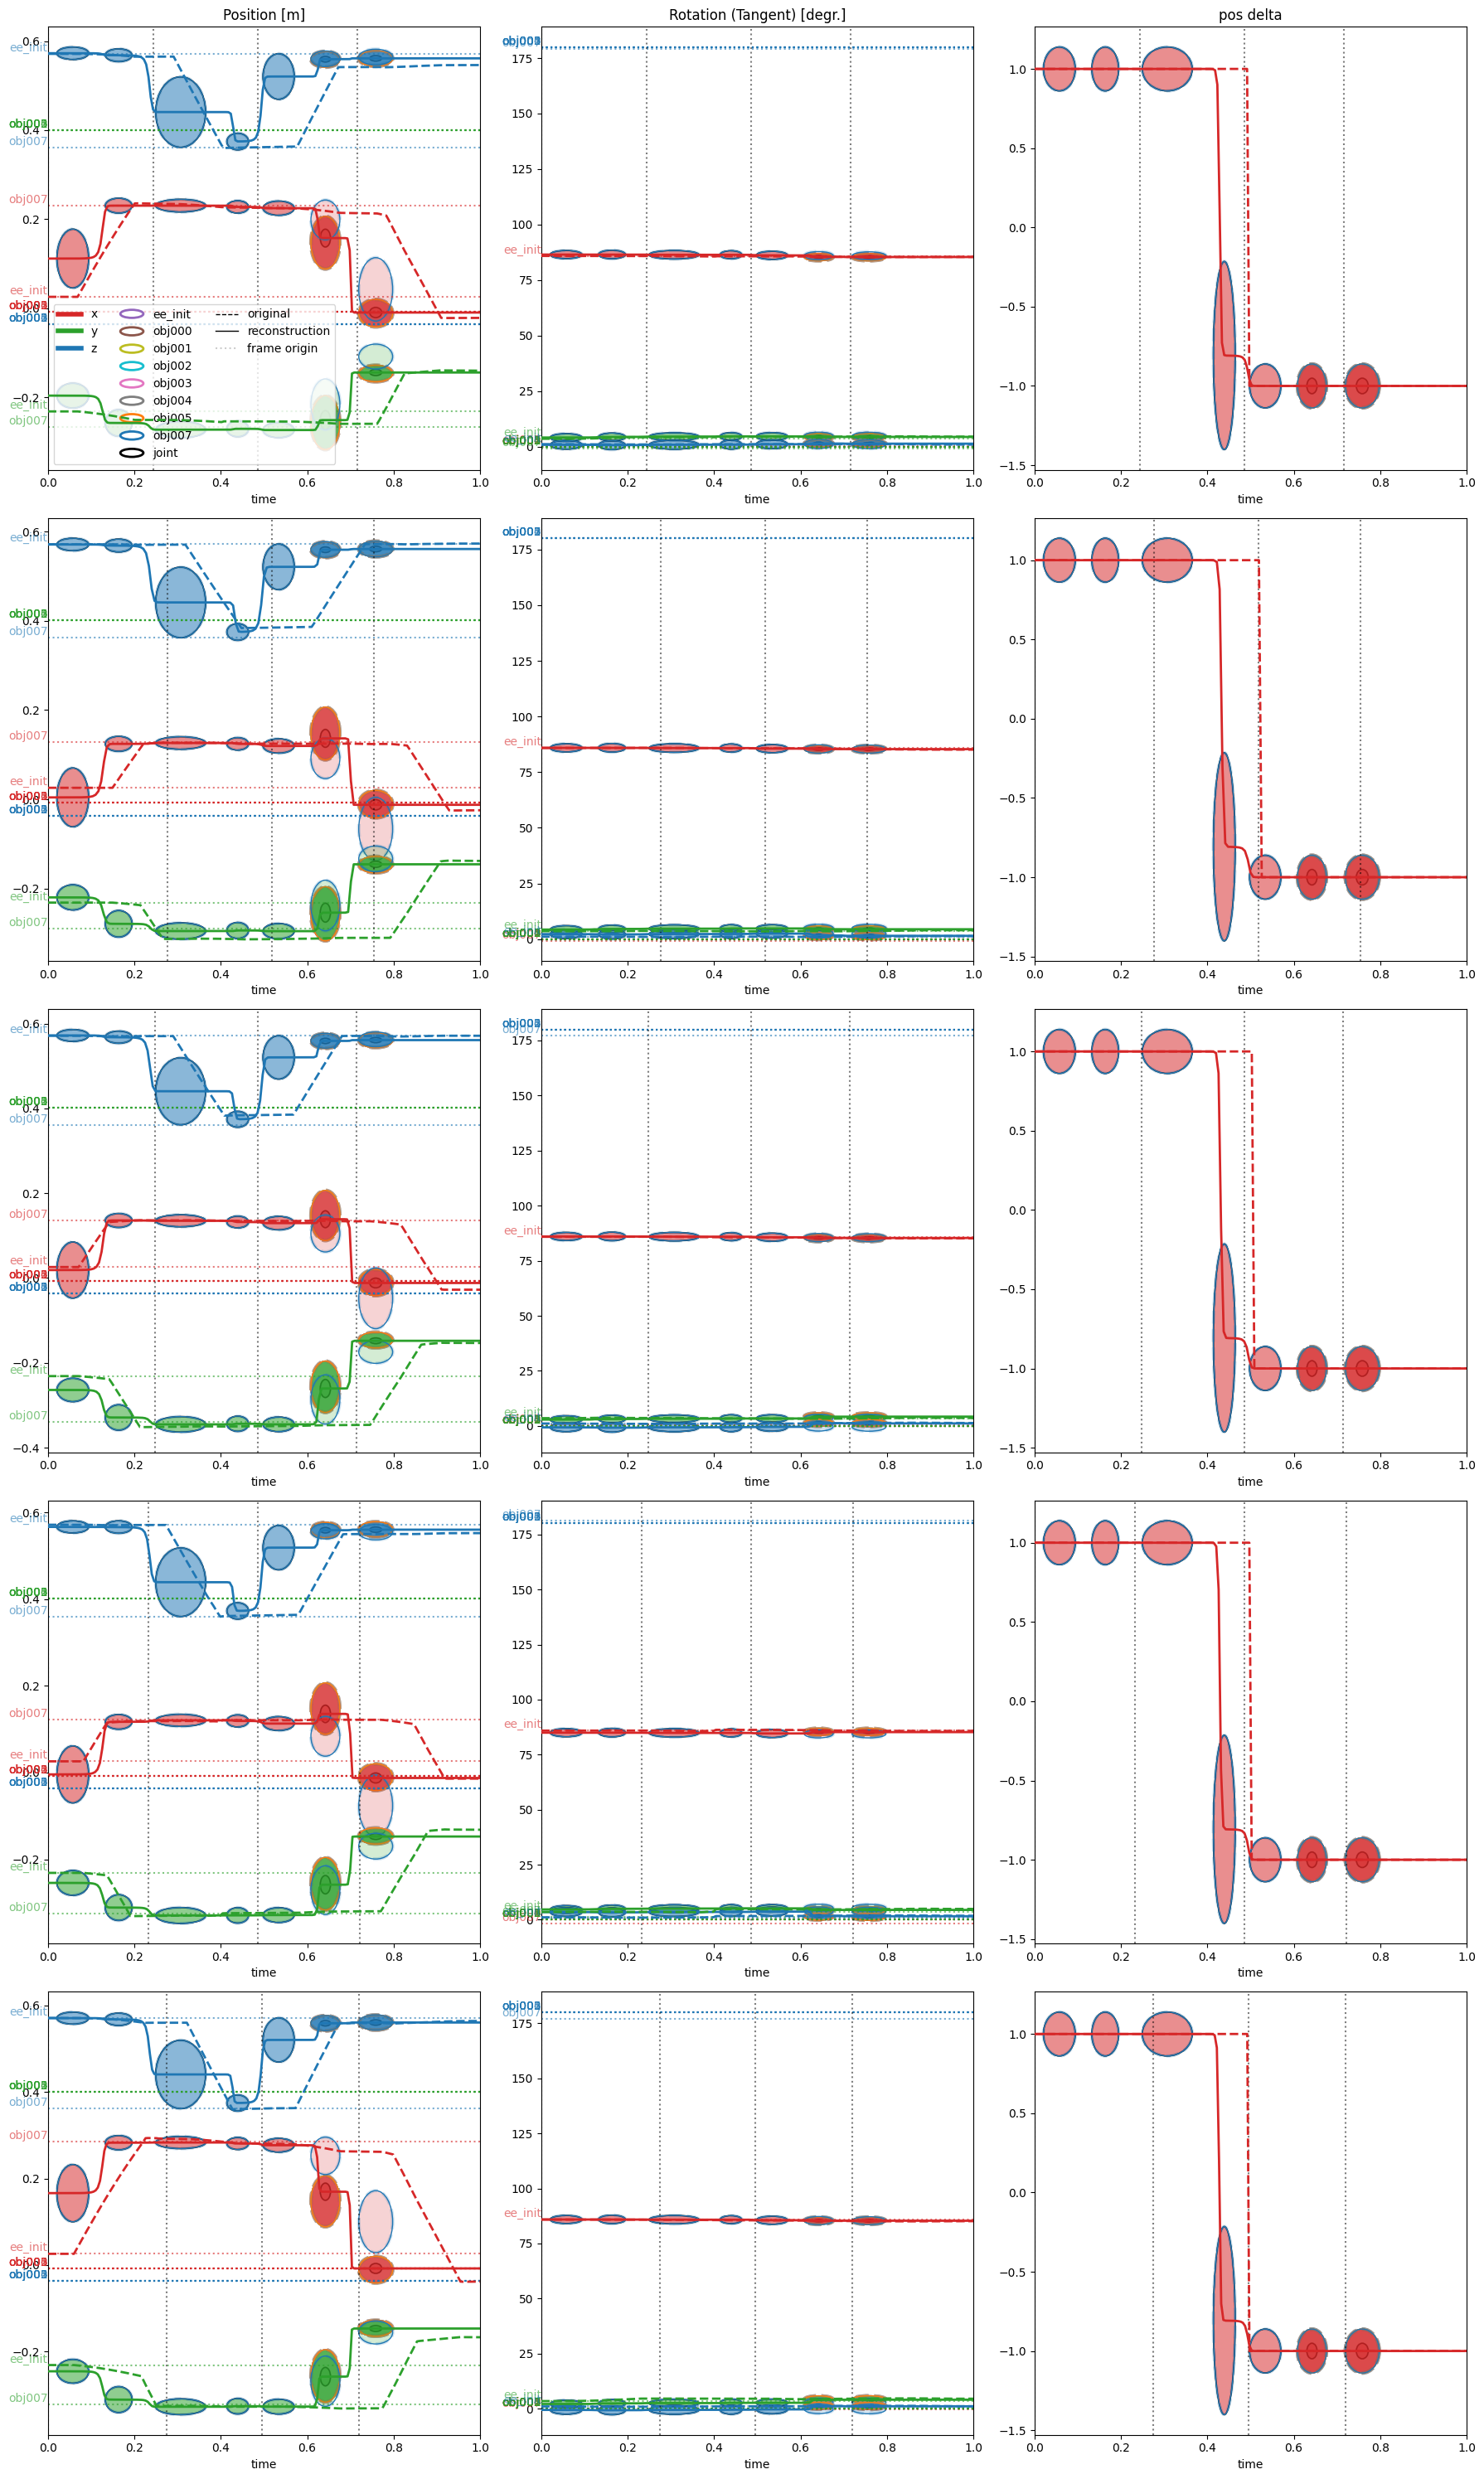

In [17]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


In [18]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)


IndexError: tuple index out of range